In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
data1 = pd.read_csv('ex2data1.txt', names=['text1', 'text2', 'admitted'])
data1.head()

,text1,text2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data1.describe()

,text1,text2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


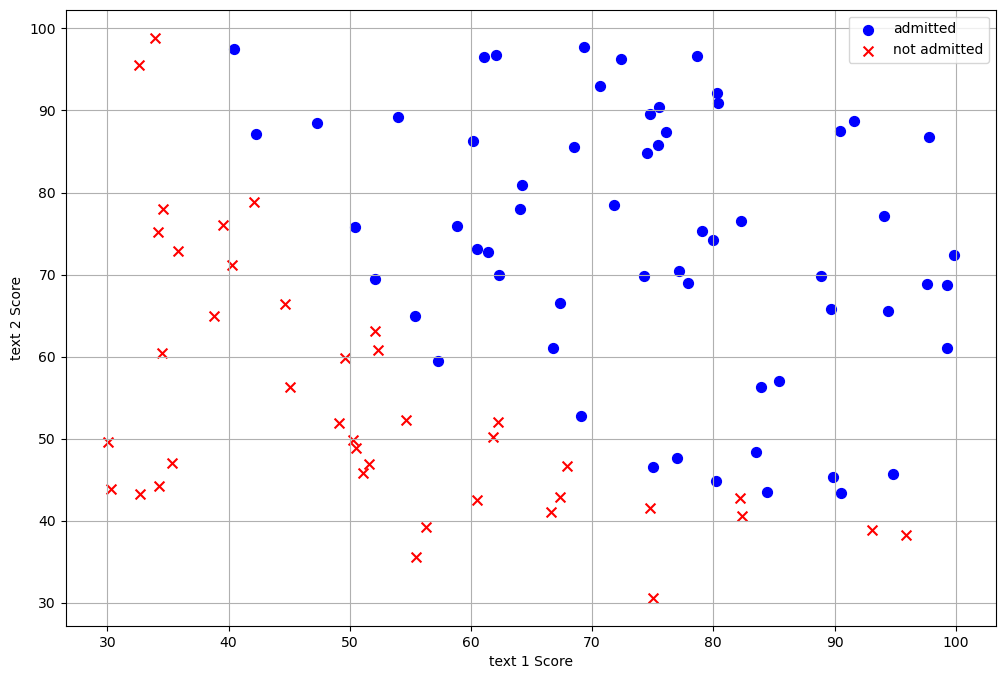

In [4]:
positive = data1[data1["admitted"].isin([1])]
negative = data1[data1["admitted"].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['text1'], positive['text2'], s=50, c='b', marker='o', label='admitted')   
ax.scatter(negative['text1'], negative['text2'], s=50, c='r', marker='x', label='not admitted')

ax.legend()   
ax.grid(True)
ax.set_xlabel('text 1 Score')
ax.set_ylabel('text 2 Score')
plt.show()

In [5]:
def get_X(df): # read features
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones is a frame with m rows and 1 columns
    data = pd.concat([ones, df], axis=1)  # Combine data, merge by column
    return data.iloc[:, :-1].to_numpy()  # This operation returns an ndarray, not a matrix, which converts data in the form of a dataframe into an array.
 
def get_y(df):
    return np.array(df.iloc[:, -1])

def normalize_feature(df):  # feature engineering
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [6]:
X = get_X(data1)
y = get_y(data1)

## Logistic Regression with sklearn

In [7]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X, y.ravel())
model.score(X, y)

0.89

## Sigmoid function
g represents a commonly used logistic function as S-shaped function (sigmoid function) with the formula:
 \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
we get the hypothesis function for the logistic regression model:
\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Cost function
\\[J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)}\\]

In [9]:
def cost(theta, X, y):
    theta=np.matrix(theta) 
    X=np.matrix(X)
    y=np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))  # The first term of the formula
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))  #The second term of the formula
    return np.sum(first - second) / (len(X))

In [10]:
# add a ones column - this makes the matrix multiplication work out easier
data1.insert(0, 'Ones', 1) 

# set X (training data) and y (target variable)
cols = data1.shape[1] 
X = data1.iloc[:,0:cols-1] 
y = data1.iloc[:,cols-1:cols] 

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values) 
y = np.array(y.values) 
theta = np.zeros(3) 

In [11]:
cost(theta, X, y)

0.6931471805599453

## Gradient Descent
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [12]:
def gradient(theta, X, y):
    theta=np.matrix(theta) 
    X=np.matrix(X) 
    y=np.matrix(y) 
    
    temp=np.matrix(np.zeros(theta.shape)) 
    parameters= int(theta.ravel().shape[1])  

    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y     # h_theta(x) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i]) 
        grad[i] = np.sum(term) / len(X)
    
    return grad

In [13]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

In [14]:
# Optimization with scipy
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X,y))
result

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

In [15]:
# Check the const function
cost(result[0], X, y)

0.20349770158947458

## Prediction and Validation

In [16]:
def predictA(x, theta):
    prob = sigmoid(x @ theta)
    return(prob >= 0.5).astype(int)      #  return 1 or 0

In [17]:
final_thetal = result[0]
y_pred = predictA(X, final_thetal)

print(classification_report(y, y_pred))

# precision = TP / (TP+FP)
# High precision indicates that the model is accurate in its positive predictions.
# recall = TP / (TP+FN)
# High recall means that the model is good at identifying most of the actual positive instances.
# f1-score = 2 * (precision*recall) / (precision+recall)
# The f1-score is a single metric that combines both precision and recall, with a high value indicating good performance in both aspects.

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



In [18]:
def predictB(theta, X): 
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]  #大于0.5的数取值为1，小于0.5的为0

In [19]:
# Check the accuracy
theta_min = np.matrix(result[0])
predictions = predictB(theta_min, X)
correct = [1 if ((a ==1 and b ==1) or (a==0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))

print('accuracy = {0}%'.format(accuracy))

accuracy = 89%


## Look for the decision boundary
when $g(z) = 0.5$, which means $1 = e^{-\theta \cdot x}$, we can find the decision boundary is given as:
\\[ \theta \cdot X = 0\\]

In [20]:
# the final theta is:
print (result[0])

[-25.16131863   0.20623159   0.20147149]


In [21]:
coef = -(result[0]/ ((result[0])[2])) 
print(coef)

plt_x = np.arange(130, step=0.1) 
plt_y = coef[0] + coef[1]*plt_x

[124.88774019  -1.02362668  -1.        ]


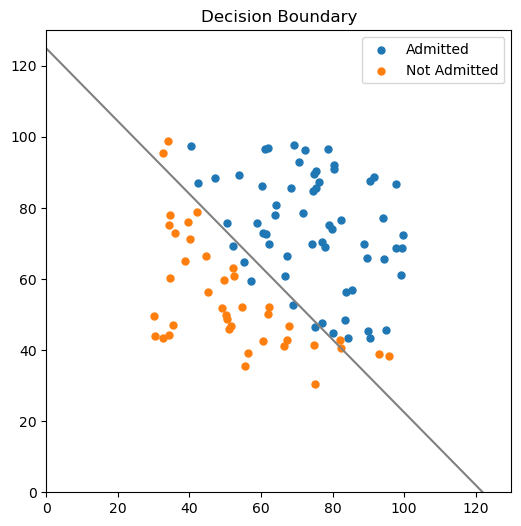

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))  # size 6x6 inches

ax.scatter(data1[data1['admitted'] == 1]['text1'], data1[data1['admitted'] == 1]['text2'], s=25, label='Admitted')
ax.scatter(data1[data1['admitted'] == 0]['text1'], data1[data1['admitted'] == 0]['text2'], s=25, label='Not Admitted')

# plot the decision boundary
ax.plot(plt_x, plt_y, 'grey')

ax.set_xlim(0, 130)
ax.set_ylim(0, 130)
ax.set_title('Decision Boundary')
ax.legend()

plt.show()


# Addressing Overfitting

## regularized cost
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [29]:
def costreg(theta,X,y,learningRate):
    theta=np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second=np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    reg=(learningRate/(2*len(X))*np.sum(np.power(theta[:,1:theta.shape[1]],2)))
    return np.sum(first - second) / len(X) + reg

## gradient descent

\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

In [30]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters) 
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad            

In [31]:
learningRate = 1

In [33]:
print(cost(theta, X, y))
costreg(theta, X, y, learningRate)

0.6931471805599453


0.6931471805599453

In [37]:
resultreg = opt.fmin_tnc(func=costreg, x0=theta, fprime=gradientReg, args=(X, y, learningRate))
print(result)
resultreg

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)


(array([-25.07219129,   0.20554396,   0.20072337]), 34, 1)

In [41]:
theta_min = np.matrix(resultreg[0])
predictions = predictB(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%


## Test with other dataset

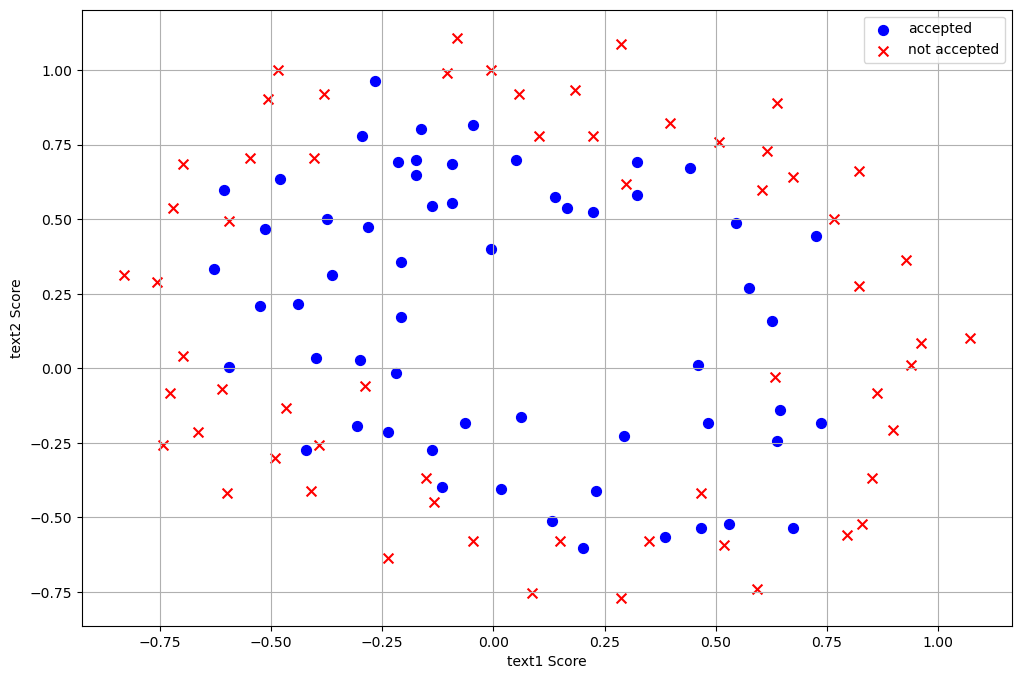

In [46]:
data2=pd.read_csv('ex2data2.txt',names=['text1','text2', 'accepted'])

positive = data2[data2['accepted'].isin([1])] 
negative = data2[data2['accepted'].isin([0])] 

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['text1'], positive['text2'], s=50, c='b', marker='o', label='accepted')   
ax.scatter(negative['text1'], negative['text2'], s=50, c='r', marker='x', label='not accepted')

ax.legend()
ax.grid()
ax.set_xlabel('text1 Score')  
ax.set_ylabel('text2 Score')   
plt.show()



In [47]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  #获取data2的列数
X2 = data2.iloc[:,1:cols] #取所有列每一行的数据
y2 = data2.iloc[:,0:1] #取第一和第二列每一行的数据

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values) #将数值转换为数组
y2 = np.array(y2.values)
theta2 = np.zeros(11) #创建长度为11的零数组

In [48]:
degree = 5
x1 = data2['text1']
x2 = data2['text2']

data2.insert(3, 'Ones', 1) # insert a ones column at 4-th column

for i in range(1, degree):
    for j in range(0, i+1):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('text1', axis=1, inplace=True)#删除表头为Test 1的列，axis=1表示默认删除行或列，inplace=True表示原数组被data2替换.
data2.drop('text2', axis=1, inplace=True)#删除表头为Test 2的列，axis=1表示默认删除行或列，inplace=True表示原数组被data2替换.

data2.head()

,accepted,Ones,F10,F11,F20,F21,F22,F30,F31,F32,F33,F40,F41,F42,F43,F44
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,0.000007,0.000094,0.001286,0.017551,0.239497
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,0.000074,-0.000546,0.004035,-0.029801,0.220095
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,0.002086,-0.006757,0.021886,-0.070895,0.229642
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,0.019775,-0.026483,0.035465,-0.047494,0.063602
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,0.069393,-0.062956,0.057116,-0.051818,0.047011


In [52]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  #获取data2的列数
X2 = data2.iloc[:,1:cols] #取所有列每一行的数据
y2 = data2.iloc[:,0:1] #取第一和第二列每一行的数据

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values) #将数值转换为数组
y2 = np.array(y2.values)
theta2 = np.zeros(15) #创建长度为11的零数组

In [53]:
result2 = opt.fmin_tnc(func=costreg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([ 1.28775611,  0.56747242,  1.11842249, -2.20672756, -0.92832316,
        -1.62521768, -0.03664129, -0.36909356, -0.33634634, -0.47660815,
        -1.67872046, -0.05978775, -0.62663106, -0.26311979, -1.54858491]),
 32,
 1)

In [55]:
theta_min = np.matrix(result2[0])
predictions = predictB(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
#predictions为预测值,y为实际值.zip为打包对象函数，将(predictions, y)打包成元组，并赋值为（a,b），然后判断正确的则返回1，判断错误的返回0
accuracy = (sum(map(int, correct)) % len(correct))
# map(int, correct):将crrect列表内容的类型映射成int型，原来应该布尔型.sum为求和函数，%为求模运算，计算除法的余数。
#实际是求1占数据总数的比例
print ('accuracy = {0}%'.format(accuracy))

accuracy = 97%


In [56]:
from sklearn import linear_model#调用sklearn的线性回归包
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())
model.score(X2, y2)

0.8220338983050848